In [1]:
!make -C .. scenario_prop scenario_endpoints

make: Entering directory '/home/martibosch/data-science/lausanne-greening-scenarios'
make: Nothing to be done for 'scenario_prop'.
make: Nothing to be done for 'scenario_endpoints'.
make: Leaving directory '/home/martibosch/data-science/lausanne-greening-scenarios'


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy import stats

In [3]:
scenario_prop_filepath = '../data/processed/scenario-prop.nc'
scenario_endpoints_filepath = '../data/processed/scenario-endpoints.nc'
biophysical_table_filepath = '../data/processed/biophysical-table.csv'

In [4]:
scenario_prop_ds = xr.open_dataset(scenario_prop_filepath)
scenario_endpoints_ds = xr.open_dataset(scenario_endpoints_filepath)

In [5]:
biophysical_df = pd.read_csv(biophysical_table_filepath)

In [6]:
num_plot_cols = 4
_plot_ds = scenario_prop_ds.sortby('change_prop').sel(
    change_prop=np.linspace(0, 1, num_plot_cols + 1)[1:-1])

## 1. Bar plots

In [7]:
start_lulc_da = scenario_endpoints_ds['LULC'].sel(change_prop=0).isel(
    scenario_run=0, drop=True)
end_lulc_da = scenario_endpoints_ds['LULC'].sel(change_prop=1).isel(
    scenario_run=0, drop=True)

lulc_nodata = start_lulc_da.attrs['nodata']

In [8]:
# prepare a LULC change df which counts the number of pixels of each LULC
# class changed for each proportion of upgraded pixels
# for proportions of changed pixels other than 0 or 1, we need to
# consider each scenario run to build the confidence intervals in the bar
# plot
lulc_df = pd.concat([
    pd.concat([
        pd.DataFrame({
            'scenario_run': _scenario_run,
            **{
                key: values
                for key, values in zip(['lucode', 'num_pixels'],
                                       np.unique(_lulc_da, return_counts=True))
            }
        }) for _scenario_run, _lulc_da in change_prop_da.where(
            change_prop_da != start_lulc_da, lulc_nodata).groupby(
                'scenario_run')
    ]).assign(change_prop=change_prop)
    for change_prop, change_prop_da in _plot_ds['LULC'].groupby('change_prop')
]).merge(biophysical_df[['lucode', 'description']],
         on='lucode').groupby(['description', 'scenario_run', 'change_prop'
                               ])['num_pixels'].sum().reset_index()

# when we change all the pixels, there is no possible randomness
end_lulc_df = pd.DataFrame(
    np.column_stack(
        np.unique(end_lulc_da.where(end_lulc_da != start_lulc_da, lulc_nodata),
                  return_counts=True)),
    columns=['lucode', 'num_pixels']).merge(
        biophysical_df[['lucode', 'description']],
        on='lucode').groupby('description')['num_pixels'].sum().reset_index()
end_lulc_df['scenario_run'] = 0
end_lulc_df['change_prop'] = 1

lulc_df = pd.concat([lulc_df, end_lulc_df])

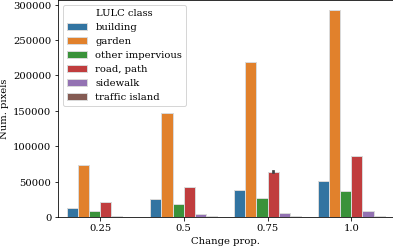

In [9]:
ax = sns.barplot(x='change_prop', y='num_pixels', hue='description', data=lulc_df)
ax.set_xlabel('Change prop.')
ax.set_ylabel('Num. pixels')
ax.legend().set_title('LULC class')
ax.figure.savefig('../reports/figures/greening-lulc-change.pdf')

## 2. Map plots

In [10]:
def _get_mode(data):
    _dims = data.dims[1:]
    return xr.DataArray(stats.mode(data, axis=0).mode[0],
                        dims=_dims,
                        coords={dim: data.coords[dim]
                                for dim in _dims})

In [11]:
plot_ds = xr.concat([
    xr.Dataset({
        'LULC': _plot_ds['LULC'].groupby('change_prop').map(_get_mode),
        'T': _plot_ds['T'].mean(dim='scenario_run')
    }),
    scenario_endpoints_ds.sel(change_prop=1)
],
                    dim='change_prop')

change_props = plot_ds['change_prop']
cbar_kwargs = {'pad': 0.025}

### 2.1 LULC

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


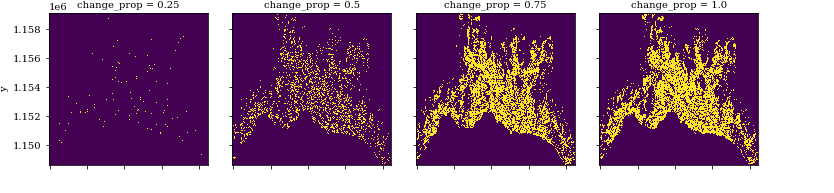

In [12]:
g = (plot_ds['LULC'] - start_lulc_da).astype(bool).plot(
    col='change_prop', cbar_kwargs=cbar_kwargs)

# post-process figure to be the top row of a facet grid
# begin: set a transparent cbar rather than removing it so that the plot
# columns are aligned with the other plots
# g.cbar.set_alpha(0)
g.cbar.set_label('$T \; [\degree C]$', alpha=0)
g.cbar.outline.set_alpha(0)
g.cbar.patch.set_alpha(0)
g.cbar.solids.set_alpha(0)
g.cbar.ax.yaxis.set_tick_params(color=(0, 0, 0, 0))
cbar_labels = g.cbar.ax.get_yticklabels()
for cbar_label in cbar_labels:
    cbar_label.set_alpha(0)
# now that the labels are invisible, set them to a text of the same length so
# that the plot columns are aligned with the other plots
g.cbar.ax.set_yticklabels(['20.0' for _ in cbar_labels])
# end
g.set_xlabels('')
for ax in g.axes.flat:
    # set transparent labels rather than removing them to have aligned
    for label in ax.get_xticklabels():
        label.set_alpha(0)
    # set transparent offset text (of scientific notation)
    ax.xaxis.get_offset_text().set_alpha(0)

# save the figure
g.fig.savefig('../reports/figures/scenarios-prop-lulc.png')

### 2.2 Temperature

#### 2.2.1 Air temperature

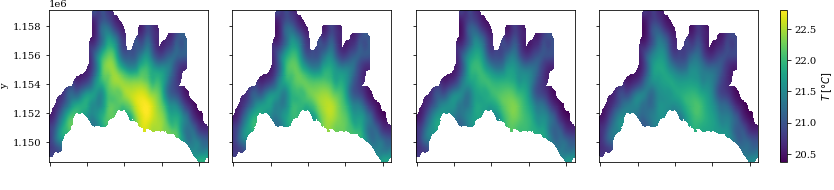

In [13]:
g = plot_ds['T'].plot(col='change_prop', cbar_kwargs=cbar_kwargs)

# post-process figure to be the middle row of a facet grid
g.cbar.set_label('$T \; [\degree C]$')
# g.cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4s'))
g.set_titles('')
g.set_xlabels('')
for ax in g.axes.flat:
    # set transparent labels rather than removing them to have aligned
    for label in ax.get_xticklabels():
        label.set_alpha(0)
    # set transparent offset text (of scientific notation)
    ax.xaxis.get_offset_text().set_alpha(0)

# save the figure
g.fig.savefig('../reports/figures/scenarios-prop-T.png')

#### 2.2.2 Heat mitigation

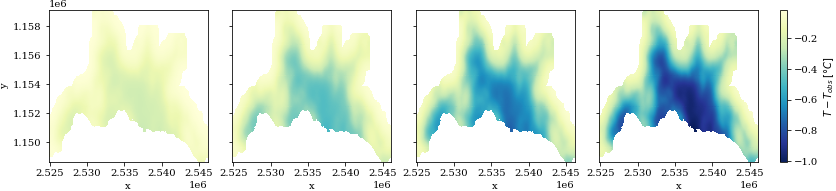

In [14]:
g = (plot_ds['T'] - scenario_endpoints_ds['T'].sel(change_prop=0).isel(
    scenario_run=0, drop=True)).plot(col='change_prop',
                                     cmap='YlGnBu_r',
                                     cbar_kwargs=cbar_kwargs)
g.cbar.set_label('$T - T_{obs} \; [\degree C]$')

# post-process figure to be the bottom row of a facet grid
g.set_titles('')

# save the figure
g.fig.savefig('../reports/figures/scenarios-prop-mitigation.png')

## 3. Regression plots

In [15]:
df = scenario_prop_ds['T'].mean(dim=['x', 'y'],
                                skipna=True).to_dataframe().reset_index()

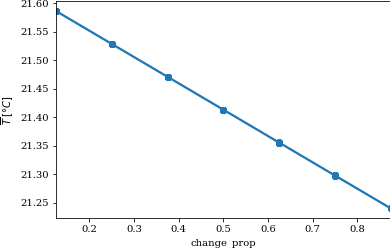

In [16]:
ax = sns.regplot(x='change_prop', y='T', data=df.dropna())
ax.set_ylabel('$\\overline{T} \; [\degree C]$')

ax.figure.savefig('../reports/figures/scenarios-prop-regplot.pdf',
                  pad_inches=0.02)

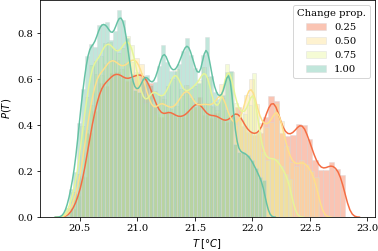

In [17]:
fig, ax = plt.subplots()

colors = sns.color_palette('Spectral', n_colors=len(change_props))
for color, change_prop in zip(colors, change_props):
    sns.distplot(plot_ds['T'].sel(change_prop=change_prop, method='nearest'),
                 color=color,
                 label=f'{change_prop.item():.2f}',
                 ax=ax)

ax.legend(title='Change prop.')
ax.set_ylabel('$P(T)$')
ax.set_xlabel('$T \; [\degree C]$')

fig.savefig('../reports/figures/scenarios-prop-hists.pdf')